In [1]:
import dask.dataframe as dd
import dask.array as da
import glob
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

In [2]:
parq = glob.glob("big_processed_4.parquet/*.parquet")
ddf = dd.read_parquet(parq)

In [3]:
dd_train, dd_test = ddf.random_split([0.80, 0.2], random_state = 2019)

In [4]:
df = dd_train.compute()

In [5]:
neighbor_cols = [f'neighbor_{n}' for n in range(25)]
df[neighbor_cols] = pd.DataFrame(df.neighbors.values.tolist(), index= df.index)

In [6]:
# even though we imputed by timestamp in the spark file, some timestamps were wholly empty
mean_epa = df['imputed_epa_pm25_value'].mean()
df['imputed_epa_pm25_value'] = df['imputed_epa_pm25_value'].fillna(mean_epa)

In [7]:
df.shape

(9752724, 34)

In [10]:
df.isnull().any()

2_5um                     False
imputed_epa_pm25_value    False
imputed_hum               False
imputed_temperature       False
wind_x                    False
wind_y                    False
ndvi                      False
elevation                 False
neighbors                 False
neighbor_0                False
neighbor_1                False
neighbor_2                False
neighbor_3                False
neighbor_4                False
neighbor_5                False
neighbor_6                False
neighbor_7                False
neighbor_8                False
neighbor_9                False
neighbor_10               False
neighbor_11               False
neighbor_12               False
neighbor_13               False
neighbor_14               False
neighbor_15               False
neighbor_16               False
neighbor_17               False
neighbor_18               False
neighbor_19               False
neighbor_20               False
neighbor_21               False
neighbor

In [18]:
input_cols = [col for col in df.columns if col != "neighbors"]

In [20]:
df[input_cols].to_parquet("final_train_2.parquet")

In [21]:
import gc
del df
gc.collect()

2407

In [22]:
df = dd_test.compute()
df[neighbor_cols] = pd.DataFrame(df.neighbors.values.tolist(), index= df.index)
df['imputed_epa_pm25_value'] = df['imputed_epa_pm25_value'].fillna(mean_epa)
df.shape

(2440650, 34)

In [23]:
df[input_cols].to_parquet("final_test_2.parquet")

In [24]:
del df, ddf
gc.collect()

20

In [ ]:
# restart kernel, memory issues

In [28]:
train = dd.read_parquet("final_train_2.parquet")

In [29]:
# for today, just train it on ~1m rows
train_df = train.sample(frac = 0.103).compute()
train_df.shape

(1004531, 33)

In [30]:
neighbor_cols = [f'neighbor_{n}' for n in range(25)]
input_cols = ['imputed_epa_pm25_value', 'imputed_hum', 
              'imputed_temperature', 'wind_x','wind_y', 
              'ndvi', 'elevation'] + neighbor_cols

rf = RandomForestRegressor(n_estimators = 100)

In [31]:
%%time
rf.fit(train_df[input_cols], train_df['2_5um'])

CPU times: user 27min 32s, sys: 4.15 s, total: 27min 37s
Wall time: 27min 35s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
from joblib import dump, load
dump(rf, 'RF_20191206.joblib') 

['RF_20191206.joblib']

In [33]:
del train_df


In [43]:
del test_df

In [44]:
test = dd.read_parquet("final_test.parquet")
test_df = test.sample(frac = 0.2).compute()
test_df.shape

(612710, 33)

In [45]:
test_df['pred'] = rf.predict(test_df[input_cols])

In [46]:
mean_squared_error(test_df['2_5um'], test_df['pred'])**0.5

5.923312563326653

In [47]:
r2_score(test_df['2_5um'], test_df['pred'])

0.7557488713698111

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

(0, 200)

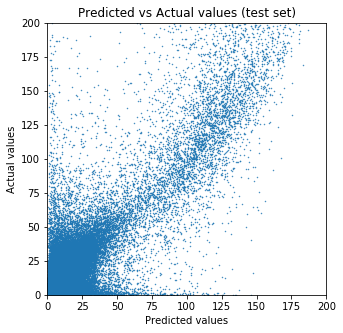

In [49]:
f, a = plt.subplots(figsize=(5,5))
a.scatter(test_df['pred'],test_df['2_5um'], s = 0.2)
a.set_title("Predicted vs Actual values (test set)")
a.set_ylabel("Actual values")
a.set_xlabel("Predicted values")
a.set_ylim(0,200)
a.set_xlim(0,200)


### one more thing for shits and giggles

In [50]:
del test_df, rf

In [51]:
gc.collect()

51

In [ ]:
train = dd.read_parquet("final_train_2.parquet")

In [52]:
ls -l *.csv

-rw-rw-r-- 1 ubuntu ubuntu    284842 Nov 17 21:44 1018_1024_avg_preds.csv
-rw-rw-r-- 1 ubuntu ubuntu  21542193 Nov 20 23:48 20191119_all_preds.csv
-rw-rw-r-- 1 ubuntu ubuntu    339372 Nov 20 23:48 20191119_avg.csv
-rw-rw-r-- 1 ubuntu ubuntu 160492286 Dec  7 01:06 20191205_all_preds.csv
-rw-rw-r-- 1 ubuntu ubuntu 150520045 Nov 17 21:51 avg_preds_w_features.csv
-rw-rw-r-- 1 ubuntu ubuntu   5833387 Dec  4 22:43 big_static_data.csv
-rw-rw-r-- 1 ubuntu ubuntu  69195141 Nov 18 00:13 errors.csv
-rw-rw-r-- 1 ubuntu ubuntu   2223059 Dec  7 01:06 latest_avg.csv
-rw-rw-r-- 1 ubuntu ubuntu       494 Nov 13 23:31 maybe_noaa_sensors.csv
-rw-rw-r-- 1 ubuntu ubuntu    349381 Nov 23 00:09 sample_output.csv
-rw-rw-r-- 1 ubuntu ubuntu     10746 Nov  1 23:46 sensor_elevations.csv
-rw-rw-r-- 1 ubuntu ubuntu     12538 Nov 22 23:33 sensor_locs1121.csv
-rw-rw-r-- 1 ubuntu ubuntu     11784 Nov 27 04:53 sensor_locs1126.csv
-rw-rw-r-- 1 ubuntu ubuntu     38903 Dec  1 17:41 sensor_locs_big_box.csv
-rw-rw-r-- 1 ub

In [57]:
d = pd.read_csv("latest_avg.csv")

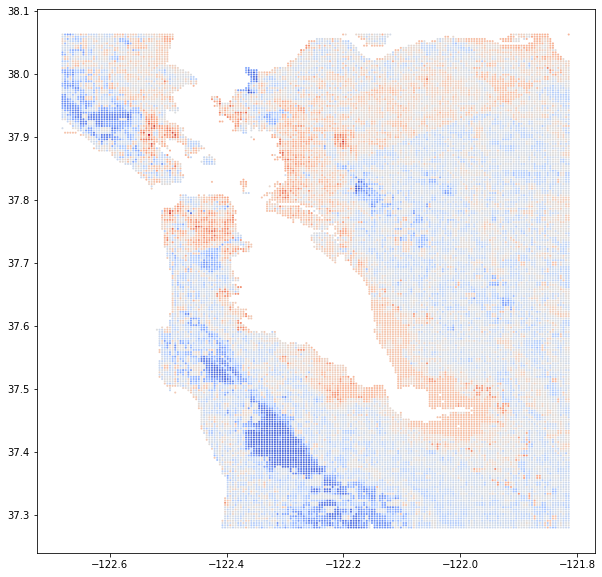

In [61]:
f, a = plt.subplots(figsize=(10,10))

plt.scatter(x = d.lon, 
            y = d.lat, 
            s = 1, 
            c = np.log(d.preds), cmap='coolwarm')

In [ ]:

s3 = session.resource('s3')
bucket = s3.Bucket(S3_BUCKET)
bucket.upload_file(file, key)


In [ ]:
s3 = boto3.resource('s3')
object_acl = s3.ObjectAcl('bucket_name','object_key')
response = object_acl.put(ACL='public-read')


In [65]:
!echo ddddd > model_output/test.txt

In [67]:
import boto3
s3 = boto3.client('s3')
s3.upload_file('model_output/test.txt', 'capstone-air-pollution', ExtraArgs={'ACL':'public-read'})

TypeError: upload_file() missing 1 required positional argument: 'Key'

In [64]:
!mkdir model_output